# 환경 세팅

## 한글폰트 설치 (런타임 재시작 필요)

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

## lightgbm 버전 다운그레이드 (런타임 재시작 필요)
- lightgbm 3.3.2 버전

In [ ]:
!pip install lightgbm==3.3.2

## XGBOOST 설치

In [ ]:
!pip install xgboost

## 런타임 재시작 후 설치 확인

In [ ]:
import lightgbm
lightgbm.__version__

'3.3.2'

In [ ]:
import xgboost
xgboost.__version__

'1.7.6'

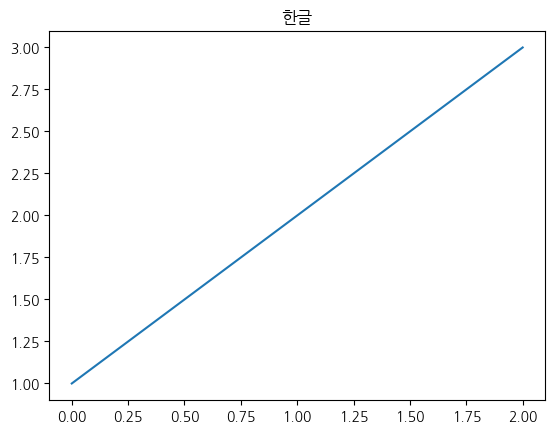

In [ ]:
import matplotlib.pyplot as plt
plt.rc("font", family="NanumGothic") # 라이브러리 불러오기와 함께 한번만 실행

plt.plot([1, 2, 3])
plt.title("한글")
plt.show()

## 구글 드라이브 연동

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# 데이터 불러오기

In [ ]:
import pandas as pd

DATA_PATH = '/content/drive/MyDrive/세미프로젝트/data/호선별 최종혼잡도/'
data = pd.read_csv(DATA_PATH + '1호선.csv')
data.head()

,YEAR,MONTH,DAY,LINE,STATION,DIRECTION,TIME_00,CONGESTION
0,2011,1,금,1,동대문,상선,TIME_05,9.1
1,2011,1,금,1,동대문,상선,TIME_06,12.2
2,2011,1,금,1,동대문,상선,TIME_07,23.3
3,2011,1,금,1,동대문,상선,TIME_08,44.6
4,2011,1,금,1,동대문,상선,TIME_09,39.6


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233520 entries, 0 to 233519
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   YEAR        233520 non-null  int64  
 1   MONTH       233520 non-null  int64  
 2   DAY         233520 non-null  object 
 3   LINE        233520 non-null  int64  
 4   STATION     233520 non-null  object 
 5   DIRECTION   233520 non-null  object 
 6   TIME_00     233520 non-null  object 
 7   CONGESTION  233520 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 14.3+ MB


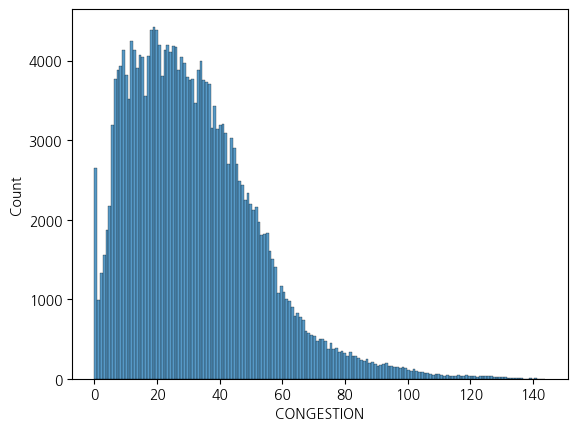

In [ ]:
# 혼잡도 분포도
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.histplot(data=data, x='CONGESTION')
plt.show()

# 머신러닝 코드

In [ ]:
from sklearn.model_selection import train_test_split

# 데이터를 독립변수(X)와 종속변수(y)로 나눕니다.
X = data[['YEAR', 'MONTH', 'DAY', 'STATION', 'DIRECTION', 'TIME_00']]
y = data['CONGESTION']

# 데이터를 학습, 테스트 데이터로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 범주형 열에 OneHot 인코딩을 적용
categorical_features = ['YEAR', 'MONTH', 'DAY', 'STATION', 'DIRECTION', 'TIME_00']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)],
    remainder='passthrough')  # 나머지 변수를 유지

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# 여러 모델 정의
models = {
    "RF_reg": RandomForestRegressor(random_state=42),
    "Lin_reg": LinearRegression(),
    "XGB_reg": XGBRegressor(random_state=42),
    "LGB_reg": LGBMRegressor(random_state=42)
 }

# 파이프라인 정의
pipelines = {}
for model_name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  # ColumnTransformer를 적용
        (model_name, model)  # 각 모델 적용
    ])
    pipelines[model_name] = pipeline

# 튜닝할 하이퍼파라미터 그리드 정의
param_dists = {
    'RF_reg': {
        'RF_reg__n_estimators': [100],
        'RF_reg__max_depth': [6, 8, 10, 12],
        'RF_reg__min_samples_split': [2, 5, 10]
    },
    'Lin_reg': {

    },
    'XGB_reg': {
        'XGB_reg__learning_rate': [0.01, 0.05, 0.1],
        'XGB_reg__n_estimators': [500],
        'XGB_reg__max_depth': [3, 5, 7],
        'XGB_reg__min_child_weight': [1, 5, 10],
        'XGB_reg__colsample_bytree': [1.0, 0.9, 0.8, 0.7],
        'XGB_reg__subsample': [1.0, 0.9, 0.8, 0.7],
        'XGB_reg__gamma': [0, 0.1, 0.2],
        'XGB_reg__alpha': [0, 0.01, 0.1],
        'XGB_reg__lambda': [0, 0.01, 0.1]
    },
    'LGB_reg': {
        'LGB_reg__learning_rate': [0.01, 0.05, 0.1],
        'LGB_reg__n_estimators': [500],
        'LGB_reg__max_depth': [6, 4, 8],
        'LGB_reg__colsample_bytree': [1.0, 0.9, 0.8, 0.7],
        'LGB_reg__subsample': [1.0, 0.9, 0.8, 0.7],
        'LGB_reg__min_child_samples': [20, 50, 100],
        'LGB_reg__reg_alpha': [0, 0.01, 0.1],
        'LGB_reg__reg_lambda': [0, 0.01, 0.1]
    }
}

In [ ]:
import warnings
from sklearn.model_selection import RandomizedSearchCV

warnings.filterwarnings('ignore')

# 모델 선택 및 RandomizedSearchCV 객체 생성
results = {}
for model_name, pipeline in pipelines.items():
    param_dist = param_dists[model_name]
    print(model_name)
    random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, n_iter=10, cv=3,
                                       scoring='neg_mean_squared_error', verbose=2, n_jobs=-1, random_state=42,
                                       return_train_score=True, refit=True)
    random_search.fit(X_train, y_train)
    print('\n')
    results[model_name] = random_search

RF_reg
Fitting 3 folds for each of 10 candidates, totalling 30 fits


Lin_reg
Fitting 3 folds for each of 1 candidates, totalling 3 fits


XGB_reg
Fitting 3 folds for each of 10 candidates, totalling 30 fits


LGB_reg
Fitting 3 folds for each of 10 candidates, totalling 30 fits




In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# 각 모델별로 최적 모델 및 하이퍼파라미터 출력, 최적 모델 저장
for model_name, result in results.items():
    best_model = result.best_estimator_
    best_params = result.best_params_

    print(f"모델: {model_name}")
    print(f"최적 하이퍼파라미터: {best_params}")

    # 최적 모델 저장
    joblib.dump(best_model, f'{model_name}_num1.pkl')

    # 테스트 데이터를 사용하여 모델의 성능을 평가합니다.
    y_test_pred = best_model.predict(X_test)

    # MAE, RMSE, Adjusted R2 Score 계산
    mae_test = mean_absolute_error(y_test, y_test_pred)
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
    n = X_test.shape[0]
    p = X_test.shape[1]
    r2_test = r2_score(y_test, y_test_pred)
    adjusted_r2_test = 1 - (1 - r2_test) * (n - 1) / (n - p - 1)

    # 결과를 출력합니다.
    print("\nTest 성능 지표:")
    print("Mean Absolute Error (MAE):", mae_test)
    print("Root Mean Squared Error (RMSE):", rmse_test)
    print("Adjusted R-squared (Adjusted R2):", adjusted_r2_test)
    print('\n\n')

모델: RF_reg
최적 하이퍼파라미터: {'RF_reg__n_estimators': 100, 'RF_reg__min_samples_split': 5, 'RF_reg__max_depth': 12}

Test 성능 지표:
Mean Absolute Error (MAE): 8.053420621977951
Root Mean Squared Error (RMSE): 11.614258229660223
Adjusted R-squared (Adjusted R2): 0.6806416832458583



모델: Lin_reg
최적 하이퍼파라미터: {}

Test 성능 지표:
Mean Absolute Error (MAE): 9.592732263217238
Root Mean Squared Error (RMSE): 12.998283027824531
Adjusted R-squared (Adjusted R2): 0.5999933114891132



모델: XGB_reg
최적 하이퍼파라미터: {'XGB_reg__subsample': 0.8, 'XGB_reg__n_estimators': 500, 'XGB_reg__min_child_weight': 10, 'XGB_reg__max_depth': 7, 'XGB_reg__learning_rate': 0.1, 'XGB_reg__lambda': 0.01, 'XGB_reg__gamma': 0.1, 'XGB_reg__colsample_bytree': 1.0, 'XGB_reg__alpha': 0.01}

Test 성능 지표:
Mean Absolute Error (MAE): 2.305130711934932
Root Mean Squared Error (RMSE): 3.74522863563344
Adjusted R-squared (Adjusted R2): 0.9667912946014372



모델: LGB_reg
최적 하이퍼파라미터: {'LGB_reg__subsample': 0.8, 'LGB_reg__reg_lambda': 0.01, 'LGB_reg__re